## Imports

In [1]:
%matplotlib inline
from utils import *
from plotting import *
from models import *

## Load Dataset (e.g., Animal-AI_v3)

In [2]:
dataset, pose = load_dataset('dataset_animalai3', file_format='.npy', load_pose=True, pose_filename='pose.npy')

In [3]:
position = pose[:,:2]
orientation = pose[:,2]

In [4]:
print(dataset.shape, pose.shape)

(20000, 84, 84, 3) (20000, 3)


### Intrinsic dimensionality

In [9]:
D = intrinsic_dimensionality(dataset, method='PCA')

In [10]:
print(D)

19


### Occupancy map

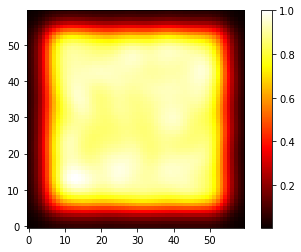

In [5]:
occ_map = occupancy_map(position, filter_width=3, padding=True, n_bins_padding=5)
plt.imshow(occ_map, cmap='hot', origin='lower')
plt.colorbar()

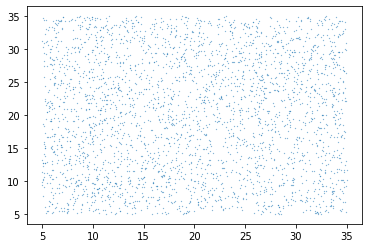

In [6]:
plt.scatter(position[:3000,0], position[:3000,1], s=.05)

## Autoencoder network

In [207]:
model = Conv_AE(n_hidden=200)

In [8]:
dataset = dataset[:5000, :]
position = position[:5000, :]
orientation = orientation[:5000]

In [92]:
train_loader = create_dataloader(dataset, batch_size=128)

In [208]:
history = train_autoencoder(model, train_loader, num_epochs=1000, learning_rate=1e-4, L2_weight_decay=0, L1_lambda=0, orth_alpha=1e3, soft_sparsity_weight=0)

Epoch 68/1000, Loss: 0.0158: 100%|█████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.56it/s]


Epoch 136/1000, Loss: 0.0136: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.92it/s]


Epoch 204/1000, Loss: 0.0130: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.08it/s]


Epoch 272/1000, Loss: 0.0123: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 25.98it/s]


Epoch 340/1000, Loss: 0.0114: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.61it/s]


Epoch 408/1000, Loss: 0.0109: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.16it/s]


Epoch 476/1000, Loss: 0.0105: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 23.30it/s]


Epoch 544/1000, Loss: 0.0102: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 25.48it/s]


Epoch 612/1000, Loss: 0.0099: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 25.66it/s]


Epoch 680/1000, Loss: 0.0096: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 24.61it/s]


Epoch 748/1000, Loss: 0.0093: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.06it/s]


Epoch 816/1000, Loss: 0.0091: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.13it/s]


Epoch 884/1000, Loss: 0.0089: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 24.46it/s]


Epoch 952/1000, Loss: 0.0088: 100%|████████████████████████████████████████████████████| 40/40 [00:01<00:00, 25.83it/s]


Epoch 1000/1000, Loss: 0.0086: 100%|███████████████████████████████████████████████████| 40/40 [00:01<00:00, 25.89it/s]


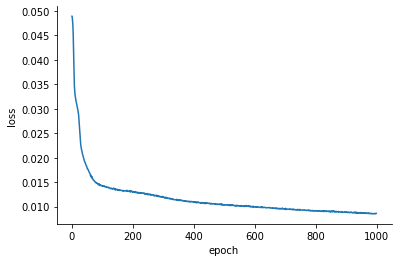

In [209]:
plt.plot(history)
plt.xlabel('epoch')
plt.ylabel('loss')
sb.despine()
plt.show()

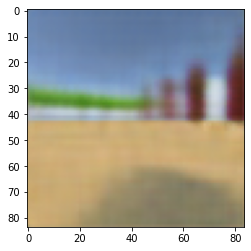

In [210]:
plt.imshow(predict(dataset[12], model))

In [211]:
embeddings = get_latent_vectors(dataset, model)

In [212]:
#np.save('embeddings_hidden200_samples5K_orth1e3_lr1e-4_epochs600.npy', embeddings)

In [213]:
#embeddings = np.load('embeddings.npy')

## Intrinsic dimensionality of population activity

In [214]:
D = intrinsic_dimensionality(embeddings, method='PCA')

In [215]:
print(D)

119


In [216]:
print( clean_embeddings(embeddings).shape[1] )

120


## Rate maps of single units

In [217]:
all_ratemaps = ratemaps(embeddings, position, n_bins=50, filter_width=3, occupancy_map=[], n_bins_padding=5)

In [218]:
plot_ratemaps(all_ratemaps)

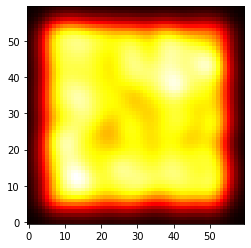

In [219]:
plt.imshow(np.sum(all_ratemaps, axis=0), cmap='hot', origin='lower')

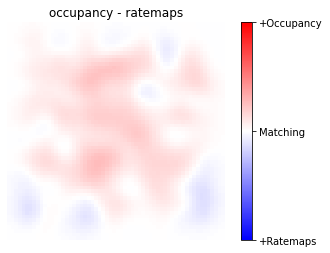

In [220]:
overall_ratemap = np.sum(all_ratemaps, axis=0).T
overall_ratemap = overall_ratemap/overall_ratemap.max()
map_diffs = occ_map - overall_ratemap
#min_ = np.min([map_diffs.min(), -map_diffs.max()])
#max_ = np.max([map_diffs.max(), -map_diffs.min()])
plt.imshow(map_diffs, cmap='bwr', origin='lower', vmin=-1, vmax=1)
plt.title('occupancy - ratemaps')
plt.axis('off')
cbar = plt.colorbar(ticks=[-1,0,1])
cbar.ax.set_yticklabels(['+Ratemaps', 'Matching', '+Occupancy']) 
plt.show()

In [221]:
degree_of_matching = np.round( np.sum(np.power(map_diffs, 2)) / np.count_nonzero(occ_map), 3)
print('MSE: ' + str(degree_of_matching))

MSE: 0.008


## Population sparseness

In [222]:
all_ratemaps_thres = np.copy(all_ratemaps)
active_thres = 0.2
all_ratemaps_thres[all_ratemaps_thres<active_thres] = 0
all_ratemaps_thres[all_ratemaps_thres>=active_thres] = 1

In [223]:
all_ratemaps_thres_avg = np.mean(all_ratemaps_thres, axis=0)

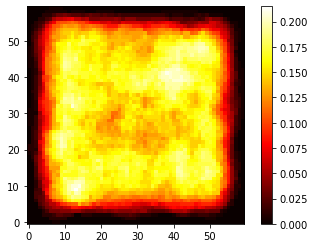

In [224]:
plt.imshow(all_ratemaps_thres_avg, origin='lower', cmap='hot')
plt.colorbar()

In [225]:
pop_sparseness = np.mean(all_ratemaps_thres_avg)

In [226]:
print(pop_sparseness)

0.1116125


(0.0, 8000.0)

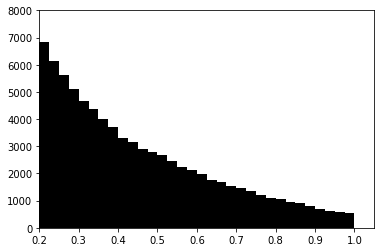

In [227]:
plt.hist(all_ratemaps.flatten(), bins=40, color='black')
plt.xlim(active_thres)
plt.ylim(0,8000)

## Place field distribution

In [228]:
n_fields, centroids, sizes = stats_place_fields(all_ratemaps, peak_as_centroid=True, min_pix_cluster=0.05, 
                                                max_pix_cluster=0.5, active_threshold=0.2)

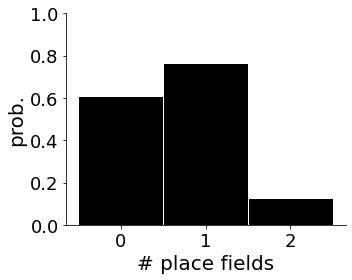

In [229]:
plot_place_field_hist(n_fields)

In [230]:
# proportion of active cells with at least one place field
prop_cells_with_place_fields(all_ratemaps, min_pix_cluster=0.02, max_pix_cluster=0.5, active_threshold=0.2)

1.0

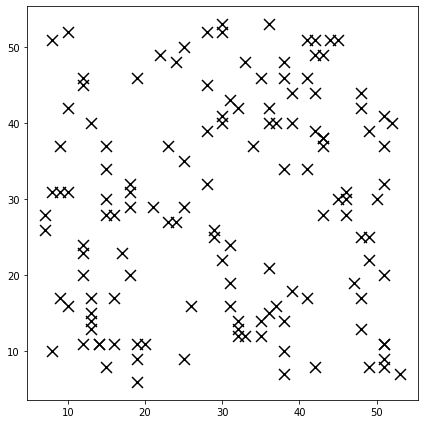

In [231]:
plt.figure(figsize=(6,6))

#plt.imshow(np.sum(all_ratemaps[:-1], axis=0), cmap='hot', origin='lower')
plt.scatter(centroids[:,0], centroids[:,1], color='black', marker='x', s=120)
#plt.axis('off')

plt.tight_layout()
plt.show()

In [232]:
print('Tiling homogeneity: ' + str(homogeneity_2Dtiling(centroids)))

Tiling homogeneity: 0.9992942323788909


## Spatial information

In [233]:
SI = spatial_information(all_ratemaps, occ_map)

In [234]:
print(np.mean(SI))

2.3207415663537097


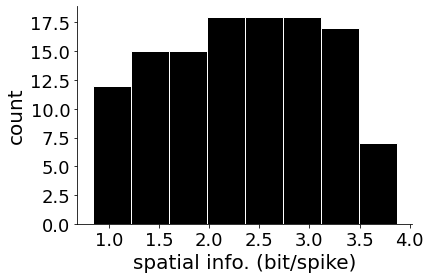

In [235]:
plt.hist(SI, color='black', bins=8, edgecolor='white')
plt.xlabel('spatial info. (bit/spike)', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
sb.despine()
plt.show()

## Check whether centric place fields are also larger, i.e., if place fields close to the wall are smaller (and also more numerous) --> https://www.sciencedirect.com/science/article/pii/S0960982222010089 

In [236]:
dists_to_wall = dist_to_walls(centroids, occ_map)

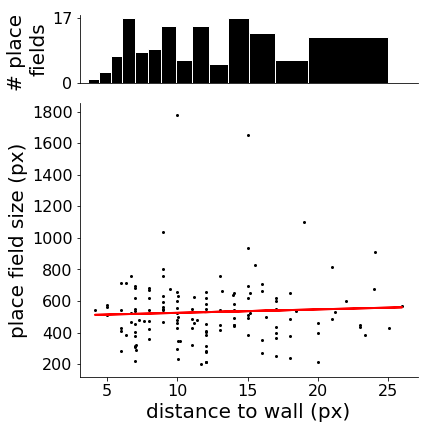

In [237]:
plot_distance_to_wall(dists_to_wall, sizes, norm_area=True)

## Check hyperbolic geometry, i.e., exponential distribution of field sizes, as in: https://www.nature.com/articles/s41593-022-01212-4 

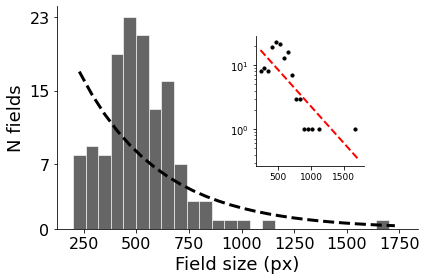

In [238]:
plot_hyperbolic_geometry(sizes, bin_width=60)

## Linear decoding of position

In [239]:
lin_score, baseline_score, ratio = linear_decoding_score(clean_embeddings(embeddings), position, n_baseline=100)

In [240]:
print('Linear decoder score: ' + str(lin_score))
print('Baseline avg.: ' + str(baseline_score[0]))
print('Ratio: ' + str(ratio))

Linear decoder score: 0.6337669735760052
Baseline avg.: 0.024202168976536327
Ratio: 26.1863709071048


## Correlation between image distance and latent vector distance

In [32]:
from scipy.stats import spearmanr

In [33]:
n_exp = 100000

spatial_pos_dist = []
latent_vec_dist = []
for i in range(n_exp):
    ind_1, ind_2 = np.random.choice(np.arange(dataset.shape[0]), 2, replace=False)
    spatial_pos_dist.append( euclidean_distance(dataset[ind_1], dataset[ind_2]) )
    latent_vec_dist.append( euclidean_distance(embeddings[ind_1], embeddings[ind_2]) )

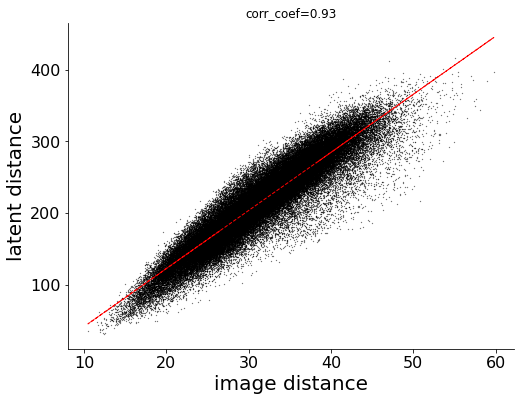

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(spatial_pos_dist, latent_vec_dist, s=.05, color='black')
m,b = np.polyfit(spatial_pos_dist, latent_vec_dist, 1)
plt.plot(spatial_pos_dist, m*np.array(spatial_pos_dist)+b, linestyle='--', color='r', linewidth=1)
#plt.title('corr_coef='+str(np.corrcoef( spatial_pos_dist, latent_vec_dist )[0][1].round(2)))
plt.title('corr_coef='+str(spearmanr( spatial_pos_dist, latent_vec_dist ).correlation.round(2)))
plt.ylabel('latent distance', fontsize=20)
plt.xlabel('image distance', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sb.despine()
plt.show()

## Head direction cells

In [128]:
all_polarmaps = polarmaps(clean_embeddings(embeddings), orientation)

In [129]:
plot_polarmaps(all_polarmaps, n_cells_plot=30)

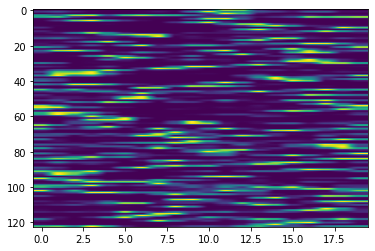

In [130]:
plt.imshow(all_polarmaps, aspect='auto', interpolation=None)

In [131]:
allocentricity = allocentricity(embeddings, orientation, n_bins=20)

In [132]:
print('Allocentric score: ' + str(allocentricity))

Allocentric score: 0.2560647933596282


## Single unit contribution (ablation exp.)

In [ ]:
single_cell_lin_scores = []
for i in range(embeddings.shape[1]):
    ablated_embed = np.delete(embeddings, i, axis=1)
    score, _ = linear_decoding_score(ablated_embed, position, n_baseline=1)
    single_cell_lin_scores.append(score)
score_full, _ = linear_decoding_score(embeddings, position, n_baseline=1)
single_cell_contribs = score_full - np.array(single_cell_lin_scores)

In [ ]:
plt.figure(figsize=(16,4))
n_active = embeddings.shape[1]
plt.bar(np.arange(1, n_active+1), single_cell_contribs, color='black', alpha=1, width=1)
plt.xlabel('Cell #', fontsize=20)
plt.ylabel('Linear decoding contrib.', fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(np.linspace(1, n_active, n_active+1, dtype=int), np.linspace(1, n_active, n_active+1, dtype=int), fontsize=18)
#plt.ylim(0,1)
sb.despine()
plt.show()

## Population coding (ablation exp.)

In [133]:
embeddings_clean = clean_embeddings(embeddings)
n_active = embeddings_clean.shape[1]

In [134]:
n_exp = 10
pop_lin_scores = np.zeros((n_active, n_exp))
for i in range(n_active):
    print(i)
    for j in range(n_exp):
        exclude = np.random.choice(np.arange(n_active), i, replace=False) 
        ablated_embed = np.delete(embeddings_clean, exclude, axis=1)
        lin_score, baseline_score, ratio = linear_decoding_score(ablated_embed, position, n_baseline=1)
        pop_lin_scores[i,j] = lin_score

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


In [135]:
mean_pop_lin_scores = np.mean(pop_lin_scores, axis=1)
std_pop_lin_scores = np.std(pop_lin_scores, axis=1)

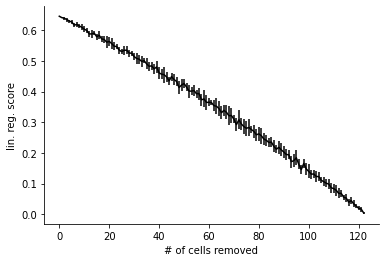

In [136]:
plt.errorbar(np.arange(n_active), mean_pop_lin_scores, yerr=std_pop_lin_scores, color='black')
plt.ylabel('lin. reg. score')
plt.xlabel('# of cells removed')
sb.despine()
plt.show()

## Control condition: shuffled hashes (permutation test)

In [143]:
embeddings_shuffled = shuffle_2D_matrix(np.copy(embeddings))

In [144]:
ratemaps_embeddings_shuffled = ratemaps(embeddings_shuffled, position, n_bins=50, filter_width=3)

In [145]:
plot_ratemaps(ratemaps_embeddings_shuffled)

In [146]:
n_fields_shuffled, centroids_shuffled, sizes_shuffled = stats_place_fields(ratemaps_embeddings_shuffled)

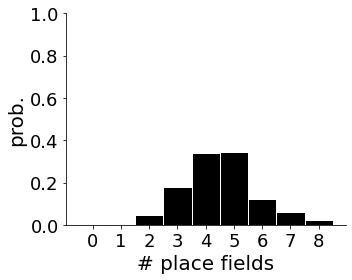

In [147]:
plot_place_field_hist(n_fields_shuffled)